## Historical Earthquake Data Analysis using K-Means Clustering

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import folium

import plotly.graph_objs as go
%matplotlib inline

---
### Data import

In [21]:
earthquakes_filepath = "earthquakes2.tsv"
data = pd.read_csv(earthquakes_filepath, sep = "\t")
data = data[1:]
data.pop(data.columns[0])
data = data.dropna(subset = ["Latitude"])
data = data.dropna(subset = ["Longitude"])
data.head()

,Year,Mo,Dy,Hr,Mn,Sec,Tsu,Vol,Location Name,Latitude,...,Total Missing,Total Missing Description,Total Injuries,Total Injuries Description,Total Damage ($Mil),Total Damage Description,Total Houses Destroyed,Total Houses Destroyed Description,Total Houses Damaged,Total Houses Damaged Description
1,1900.0,1.0,10.0,NaN,NaN,NaN,5459.0,NaN,INDONESIA: GALELA (HALMAHERA ISLAND),-0.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1900.0,1.0,11.0,9.0,7.0,0.0,NaN,NaN,JAPAN: SEA OF JAPAN,36.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1900.0,1.0,14.0,NaN,NaN,NaN,NaN,NaN,INDONESIA: JAVA: SUKABUMI,-6.84,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,3.0
4,1900.0,1.0,20.0,6.0,33.0,30.0,NaN,NaN,MEXICO,20.00,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
5,1900.0,5.0,16.0,20.0,12.0,0.0,NaN,NaN,MEXICO: NEAR COAST OF JALISCO,20.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
plates_filepath = "plate_boundaries.csv"
tectonic_plates = pd.read_csv(plates_filepath)
tectonic_plates.head()

,plate,lat,lon
0,am,30.754,132.824
1,am,30.970,132.965
2,am,31.216,133.197
3,am,31.515,133.500
4,am,31.882,134.042


---
### Data Processing

#### Combining into single date column w/ year & month

In [23]:
data = data.dropna(subset = ["Year"])
data["Year"] = data["Year"].apply(str)
lengths = data["Year"].str.len()
data["Year"] = data["Year"].str[:-2]
print(lengths.value_counts())

data = data.dropna(subset = ["Mo"])
data["Mo"] = data["Mo"].apply(str)
lengths = data["Mo"].str.len()
data["Mo"] = data["Mo"].str[:-2]
print(lengths.value_counts())

data = data.dropna(subset = ["Dy"])
data["Dy"] = data["Dy"].apply(str)
lengths = data["Dy"].str.len()
data["Dy"] = data["Dy"].str[:-2]
print(lengths.value_counts())

6    3836
Name: Year, dtype: int64
3    2876
4     953
Name: Mo, dtype: int64
4    2712
3    1113
Name: Dy, dtype: int64


In [24]:
data["Year"] = data["Year"] + "/" + data["Mo"] + "/" + data["Dy"]
data.drop("Mo", axis = 1, inplace = True)
data.drop("Dy", axis = 1, inplace = True)
data.drop("Hr", axis = 1, inplace = True)
data.drop("Sec", axis = 1, inplace = True)
data.drop("Mn", axis = 1, inplace = True)
data = data.rename(columns = {"Year" : "Date"})
data["Date"] = pd.to_datetime(data["Date"])
data.head()

,Date,Tsu,Vol,Location Name,Latitude,Longitude,Focal Depth (km),Mag,MMI Int,Deaths,...,Total Missing,Total Missing Description,Total Injuries,Total Injuries Description,Total Damage ($Mil),Total Damage Description,Total Houses Destroyed,Total Houses Destroyed Description,Total Houses Damaged,Total Houses Damaged Description
1,1900-01-10,5459.0,NaN,INDONESIA: GALELA (HALMAHERA ISLAND),-0.03,127.25,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1900-01-11,NaN,NaN,JAPAN: SEA OF JAPAN,36.50,133.50,NaN,7.8,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1900-01-14,NaN,NaN,INDONESIA: JAVA: SUKABUMI,-6.84,106.96,NaN,NaN,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,3.0
4,1900-01-20,NaN,NaN,MEXICO,20.00,-105.00,10.0,7.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
5,1900-05-16,NaN,NaN,MEXICO: NEAR COAST OF JALISCO,20.00,-105.00,60.0,7.8,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---
### Data Analysis

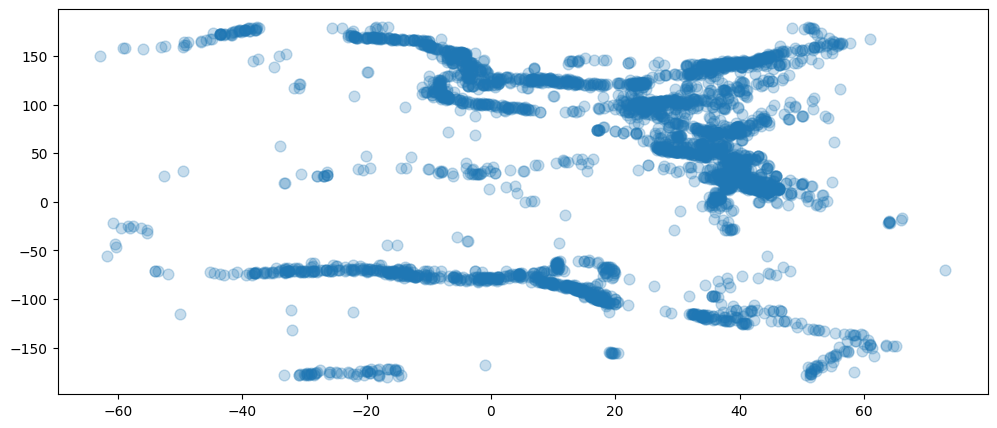

In [25]:
locations = np.array(data[["Latitude", "Longitude"]])
plt.figure(figsize = (12, 5))
plt.scatter(locations[:, 0], locations[:, 1], alpha = 0.25, s = 60)

Visually, there are roughly two distinct clusters.

On a time-magnitude graph...

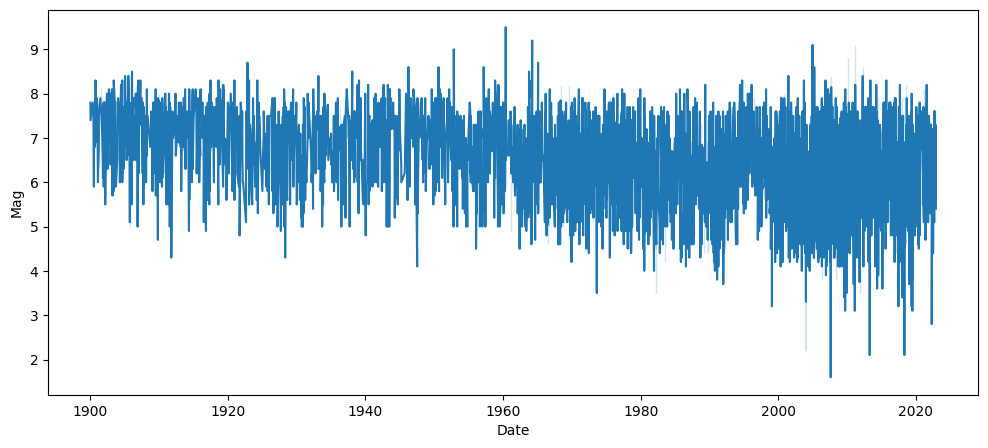

In [26]:
plt.figure(figsize = (12, 5))
timegraph = sns.lineplot(x = "Date", y = "Mag", data = data)

#### Initial clustering w/ 2 clusters

In [27]:
kmc = KMeans(n_clusters = 2)
predictions = kmc.fit_predict(locations)

unique, counts = np.unique(predictions, return_counts = True)
print(np.asarray((unique, counts)))

[[   0    1]
 [2831  994]]


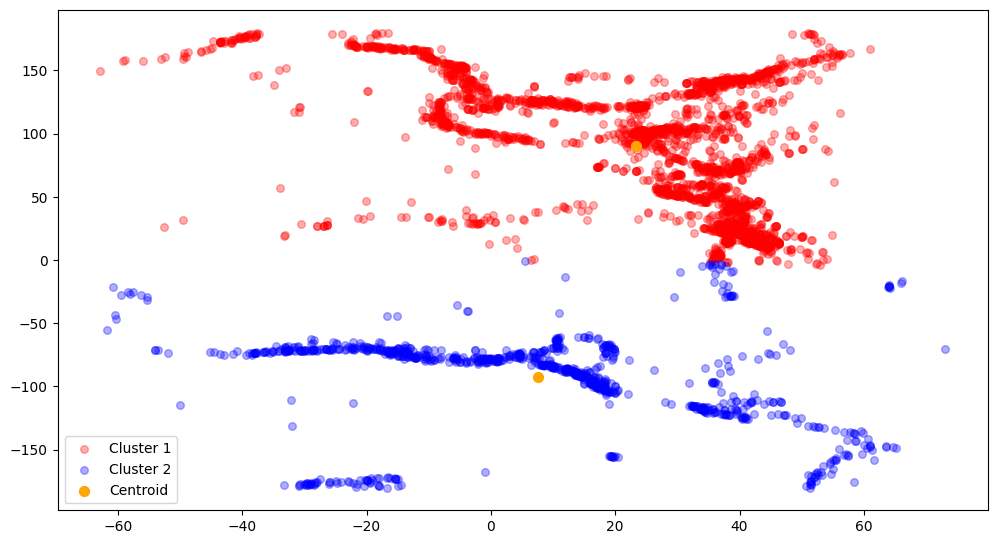

In [28]:
plt.figure(figsize = (12, 6.5))
plt.scatter(
    locations[predictions == 0, 0],
    locations[predictions == 0, 1],
    s = 30,
    alpha = 0.32,
    label = "Cluster 1",
    c = "red"
)
plt.scatter(
    locations[predictions == 1, 0],
    locations[predictions == 1, 1],
    s = 30,
    alpha = 0.32,
    label = "Cluster 2",
    c = "blue"
)
plt.scatter(
    kmc.cluster_centers_[:, 0],
    kmc.cluster_centers_[:, 1],
    s = 50,
    label = "Centroid",
    c = "orange"
)
plt.legend()
plt.show()

#### Finding optimal number of clusters

In [29]:
distortions = []
for i in range(1, 15):
    test_kmc = KMeans(i)
    test_kmc.fit_predict(locations)
    distortions.append(test_kmc.inertia_)

[Text(0, 0.5, 'WCSS (100,000)')]

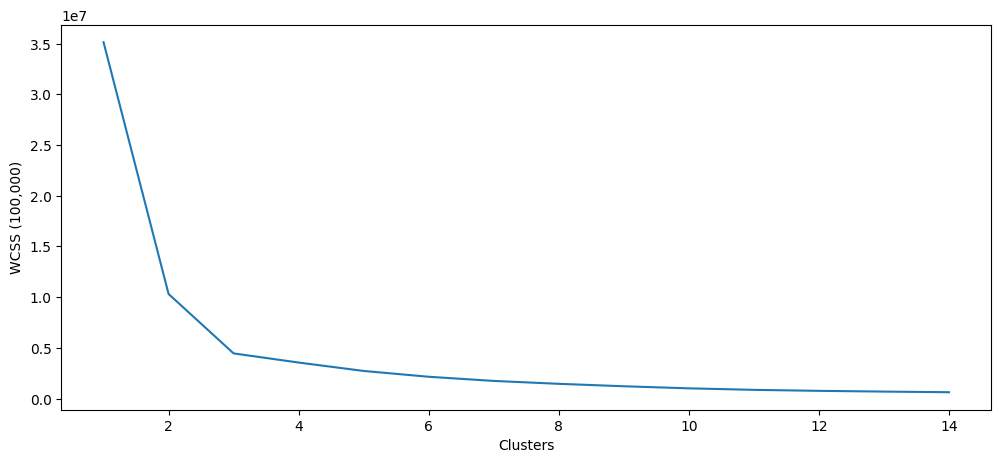

In [30]:
clusters = range(1, 15)
plt.figure(figsize = (12, 5))
elbow_graph = sns.lineplot(x = clusters, y = distortions)
elbow_graph.set(xlabel = "Clusters")
elbow_graph.set(ylabel = "WCSS (100,000)")


"Elbow" shows 3 optimal clusters, but WCSS is still very high (~100000) because of the geological nature of the data 

(data is longitude/latitude values), so we will choose 6 as the number of clusters for this dataset.

In [31]:
kmc = KMeans(n_clusters = 6)
predictions = kmc.fit_predict(locations)

In [42]:
map = folium.Figure(width = 1200, height = 1000)
tectonic = folium.Map(zoom_start = 15)

plates = list(tectonic_plates["plate"].unique())
for plate in plates:
    plate_vals = tectonic_plates[tectonic_plates["plate"] == plate]
    lats = plate_vals["lat"].values
    lons = plate_vals["lon"].values
    points = list(zip(lats, lons))
    indexes = [None] + [i + 1 for i, x in enumerate(points) \
                        if i < len(points) - 1 and abs(x[1] - points[i + 1][1]) > 300] + [None]
    for i in range(len(indexes) - 1):
        folium.vector_layers.PolyLine(points[indexes[i]:indexes[i + 1]]).add_to(tectonic)

Defining each cluster as array

In [43]:
clus1 = np.stack((locations[predictions == 0, 0], locations[predictions == 0, 1]), axis = 1)
clus2 = np.stack((locations[predictions == 1, 0], locations[predictions == 1, 1]), axis = 1)
clus3 = np.stack((locations[predictions == 2, 0], locations[predictions == 2, 1]), axis = 1)
clus4 = np.stack((locations[predictions == 3, 0], locations[predictions == 3, 1]), axis = 1)
clus5 = np.stack((locations[predictions == 4, 0], locations[predictions == 4, 1]), axis = 1)
clus6 = np.stack((locations[predictions == 5, 0], locations[predictions == 5, 1]), axis = 1)


Separating each cluster by color on the Folium map

In [44]:
for coord in clus1:
    folium.CircleMarker(location = (coord[0], coord[1]), color = "red", radius = 1).add_to(tectonic)
for coord in clus2:
    folium.CircleMarker(location = (coord[0], coord[1]), color = "blue", radius = 1).add_to(tectonic)
for coord in clus3:
    folium.CircleMarker(location = (coord[0], coord[1]), color = "purple", radius = 1).add_to(tectonic)
for coord in clus4:
    folium.CircleMarker(location = (coord[0], coord[1]), color = "magenta", radius = 1).add_to(tectonic)
for coord in clus5:
    folium.CircleMarker(location = (coord[0], coord[1]), color = "yellow", radius = 1).add_to(tectonic)
for coord in clus6:
    folium.CircleMarker(location = (coord[0], coord[1]), color = "pink", radius = 1).add_to(tectonic)
map.add_child(tectonic)
map

On the map, there are clearly certain plate boundaries with more earthquakes than other plate boundaries.

---
#### 3D clustering with magnitude as third dimension

[Text(0, 0.5, 'WCSS 100,000')]

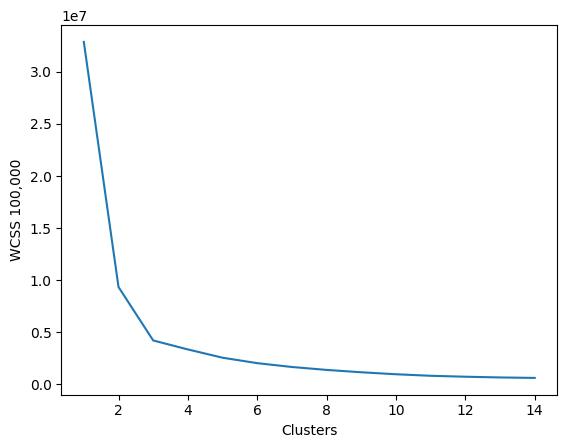

In [35]:
data = data.dropna(subset = ["Mag"])
x = data[["Latitude", "Longitude", "Mag"]].values
distortions = []
for i in range(1, 15):
    test_kmc = KMeans(n_clusters = i)
    test_kmc.fit_predict(x)
    distortions.append(test_kmc.inertia_)
elbow_graph = sns.lineplot(x = range(1, 15), y = distortions)
elbow_graph.set(xlabel = "Clusters")
elbow_graph.set(ylabel = "WCSS 100,000")

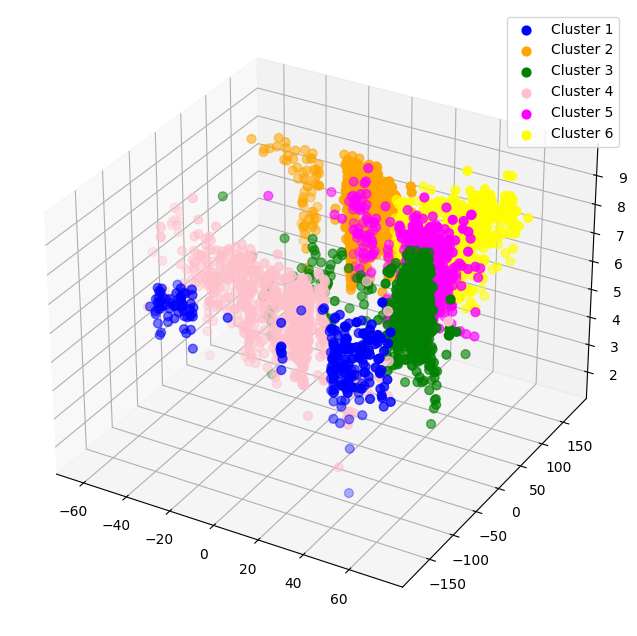

In [57]:
kmc = KMeans(n_clusters = 6)
y_clusters = kmc.fit_predict(x)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[y_clusters == 0, 0], x[y_clusters == 0, 1], x[y_clusters == 0, 2], s = 40 , color = 'blue', label = "Cluster 1")
ax.scatter(x[y_clusters == 1, 0], x[y_clusters == 1, 1], x[y_clusters == 1, 2], s = 40 , color = 'orange', label = "Cluster 2")
ax.scatter(x[y_clusters == 2, 0], x[y_clusters == 2, 1], x[y_clusters == 2, 2], s = 40 , color = 'green', label = "Cluster 3")
ax.scatter(x[y_clusters == 3, 0], x[y_clusters == 3, 1], x[y_clusters == 3, 2], s = 40 , color = 'pink', label = "Cluster 4")
ax.scatter(x[y_clusters == 4, 0], x[y_clusters == 4, 1], x[y_clusters == 4, 2], s = 40 , color = 'magenta', label = "Cluster 5")
ax.scatter(x[y_clusters == 5, 0], x[y_clusters == 5, 1], x[y_clusters == 5, 2], s = 40 , color = 'yellow', label = "Cluster 6")

ax.legend()
plt.show()

On an interactive plot...

In [60]:
Scene = dict(xaxis = dict(title = 'Latitude'), yaxis = dict(title = 'Longitude'), zaxis = dict(title = 'Magnitude'))

labels = kmc.labels_
trace = go.Scatter3d(x = x[:, 0], 
                    y = x[:, 1], 
                    z = x[:, 2], 
                    mode = 'markers', 
                    marker = dict(color = labels, size = 4.5, line = dict(color = 'black', width = 10)))
layout = go.Layout(margin = dict(l = 0, r = 0), scene = Scene, height = 800, width = 1000)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

Middle cluster seems to have far less data points above magnitude of 8.

This is likely due to this cluster having earthquakes at continental-continental convergent boundaries